In [1]:
!pip install albumentations -U
!pip install opencv-python-headless==4.1.2.30

In [2]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset

from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from math import log10
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
device = torch.device('cuda')

In [4]:
class DnCNN(nn.Module):
  def __init__(self, n_layers=18):
    super(DnCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False)
    self.relu1 = nn.ReLU(inplace=True)

    hidden_layers = []
    for _ in range(n_layers):
      hidden_layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
      hidden_layers.append(nn.BatchNorm2d(64))
      hidden_layers.append(nn.ReLU(inplace=True))
    self.hidden = nn.Sequential(*hidden_layers)
    self.out = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1, bias=False)
    
  def forward(self, x):
    out = self.relu1(self.conv1(x))
    out = self.hidden(out)
    out = self.out(out)
    return out

In [5]:
model = DnCNN(n_layers=17).to(device)
model.eval()
output = model(torch.ones(1, 3, 100, 100).to(device))

In [6]:
output.shape

torch.Size([1, 3, 100, 100])

In [15]:
class UniversalDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, gaussian_noise_level=(0, 55),
                 transform=None):
      self.data = dataset
      self.transforms = transform
      self.gaussian_noise_level = gaussian_noise_level

    def __len__(self):
        return self.data.__len__()

    def __getitem__(self, idx):
      clean_image, label = self.data.__getitem__(idx)

      noisy_image = clean_image.copy()
      gaussian_noise = np.zeros((100, 100, 3), dtype=np.float32)

      sigma = random.randint(self.gaussian_noise_level[0], self.gaussian_noise_level[1])
      gaussian_noise += np.random.normal(0.0, sigma, (100, 100, 3)).astype(np.float32)

      image = np.array(clean_image)
      image = cv2.resize(image, (100, 100))
      noisy_image = cv2.resize(np.array(noisy_image), (100, 100)).astype(np.float32)

      if self.transforms:
        img = self.transforms(image=image)['image']
      
      noisy_image += gaussian_noise
      return img, torch.Tensor(image), torch.Tensor(gaussian_noise), torch.Tensor(noisy_image)

In [8]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [16]:
train_transforms = A.Compose(
[
      A.OneOf([
               A.GaussNoise(var_limit=(10, 100), p=1),
               A.ISONoise(intensity=(0.3, 0.9), p=1),
               A.MultiplicativeNoise(p=1)
               ]),
      ToTensorV2()              
])
dataset = UniversalDataset(torchvision.datasets.STL10('.../train', download=True),
                           transform=train_transforms)

Files already downloaded and verified


In [17]:
img1, img2, _, _ = dataset.__getitem__(0)

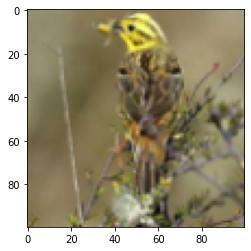

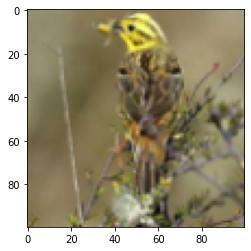

In [18]:
plt.imshow(img1.permute(1, 2, 0).numpy())
plt.show()

plt.imshow(img2.numpy().astype(np.uint8))
plt.show()

In [19]:
dataset = train_val_dataset(dataset)

train_dataset = dataset['val']

batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)

criterion = nn.MSELoss()

lr = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=lr)
model = model.to(device)

In [22]:
epochs = 5
for epoch in range(1, epochs+1):
  epoch_loss = 0
  model.train()
  for iteration, data in enumerate(train_dataloader):

      input, target, _, _ = data
      input, target = input.to(device)/255, target.to(device)/255
      
      output = model(input)

      loss = criterion(output, target.permute(0, 3, 1, 2))
      epoch_loss += loss.item()
      
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      

      print("===> Epoch[{}]({}/{}): "
            "Loss: {:.4f}".format(epoch, iteration,
                                  len(train_dataloader), 
                                  loss.item()))
  print("===> Epoch {} Complete: "
        "Avg. Loss: {:.4f}".format(epoch, 
                                    epoch_loss / len(train_dataloader)))
  

  avg_psnr = 0
  model.eval()
  with torch.no_grad():
      for data in train_dataloader:
        input, target, _, _ = data
        input, target = input.to(device)/255, target.to(device)/255
        output = model(input)
        mse = criterion(output, target.permute(0, 3, 1, 2))
        psnr = 10 * log10(1 / mse.item())
        avg_psnr += psnr
  print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(train_dataloader)))

===> Epoch[1](0/40): Loss: 0.0112
===> Epoch[1](1/40): Loss: 0.0114
===> Epoch[1](2/40): Loss: 0.0113
===> Epoch[1](3/40): Loss: 0.0108
===> Epoch[1](4/40): Loss: 0.0116
===> Epoch[1](5/40): Loss: 0.0096
===> Epoch[1](6/40): Loss: 0.0113
===> Epoch[1](7/40): Loss: 0.0086
===> Epoch[1](8/40): Loss: 0.0119
===> Epoch[1](9/40): Loss: 0.0098
===> Epoch[1](10/40): Loss: 0.0110
===> Epoch[1](11/40): Loss: 0.0098
===> Epoch[1](12/40): Loss: 0.0111
===> Epoch[1](13/40): Loss: 0.0105
===> Epoch[1](14/40): Loss: 0.0108
===> Epoch[1](15/40): Loss: 0.0090
===> Epoch[1](16/40): Loss: 0.0109
===> Epoch[1](17/40): Loss: 0.0113
===> Epoch[1](18/40): Loss: 0.0099
===> Epoch[1](19/40): Loss: 0.0112
===> Epoch[1](20/40): Loss: 0.0095
===> Epoch[1](21/40): Loss: 0.0102
===> Epoch[1](22/40): Loss: 0.0091
===> Epoch[1](23/40): Loss: 0.0093
===> Epoch[1](24/40): Loss: 0.0092
===> Epoch[1](25/40): Loss: 0.0095
===> Epoch[1](26/40): Loss: 0.0103
===> Epoch[1](27/40): Loss: 0.0085
===> Epoch[1](28/40): Loss: 0.

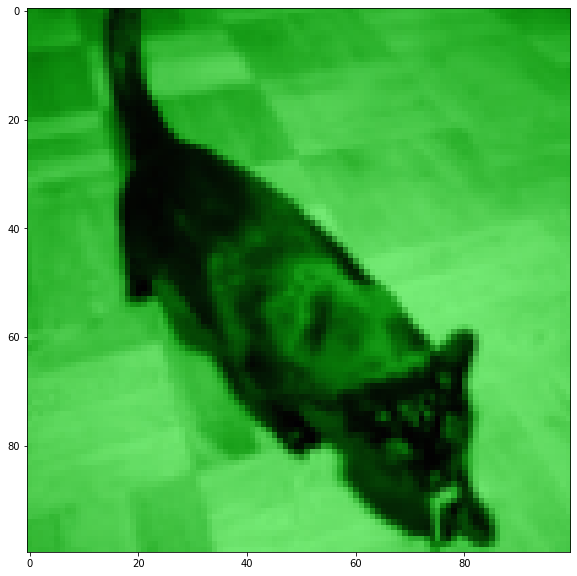

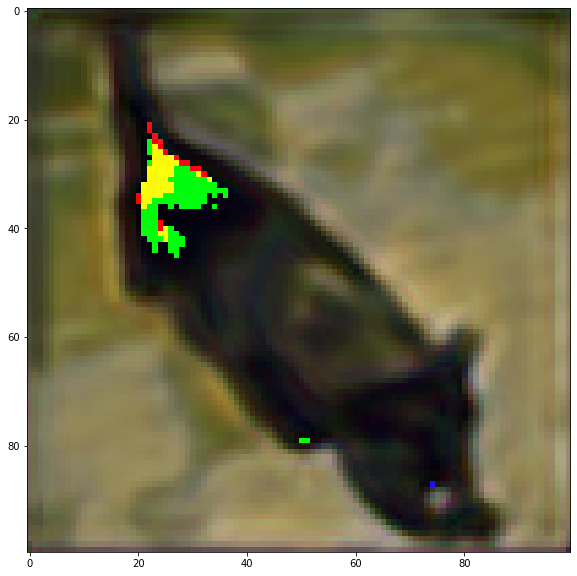

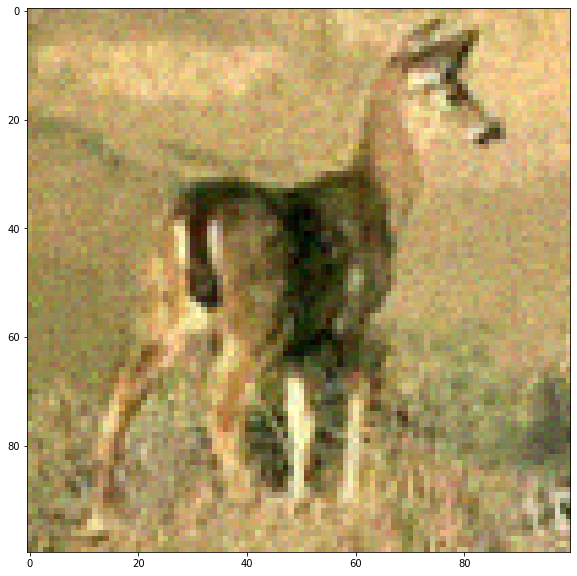

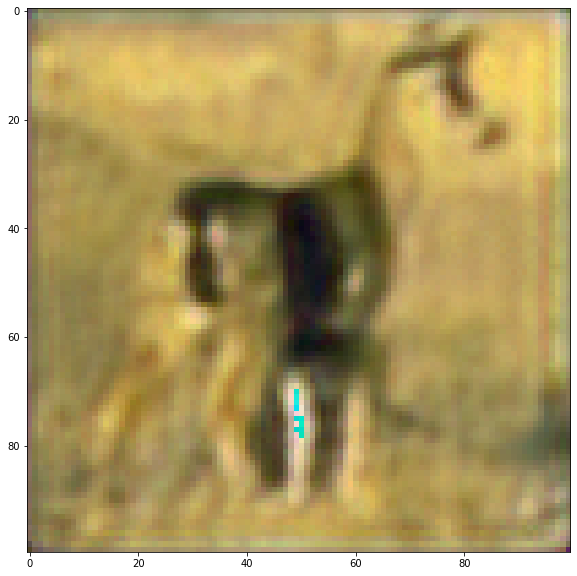

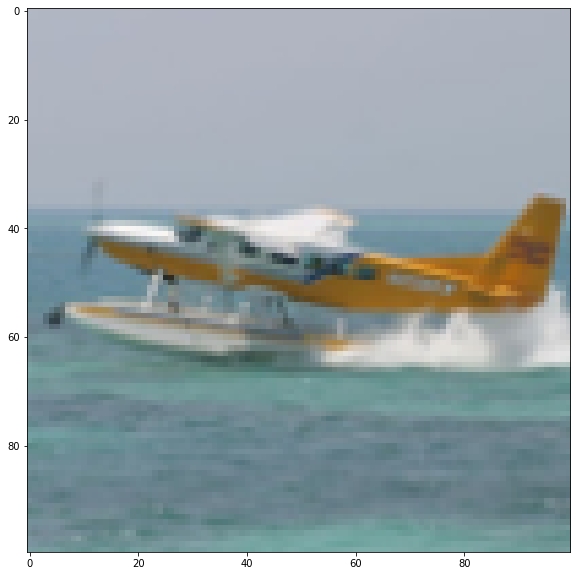

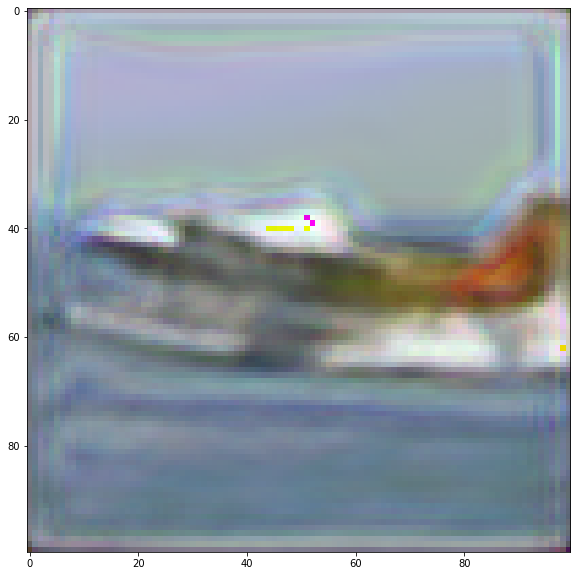

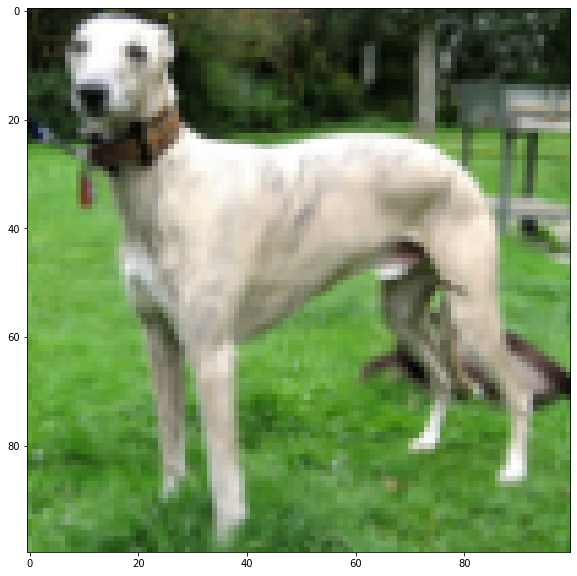

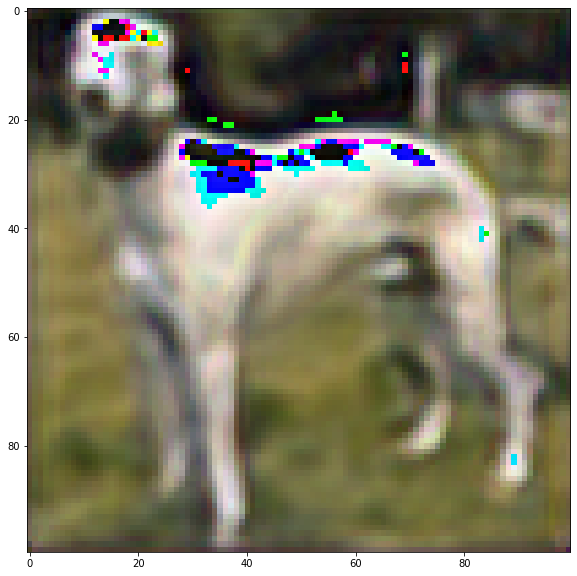

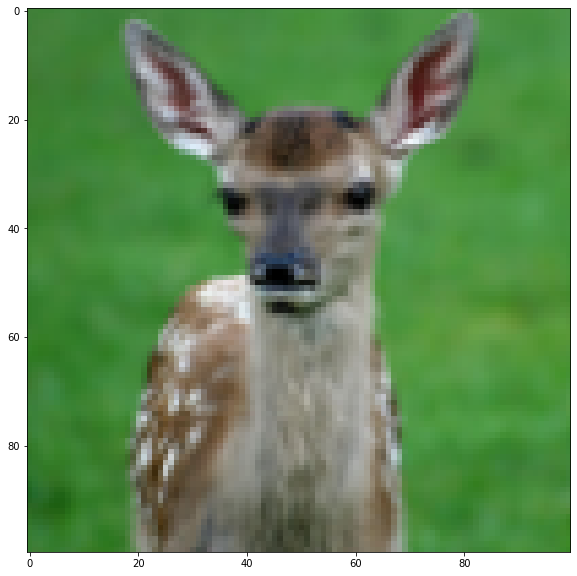

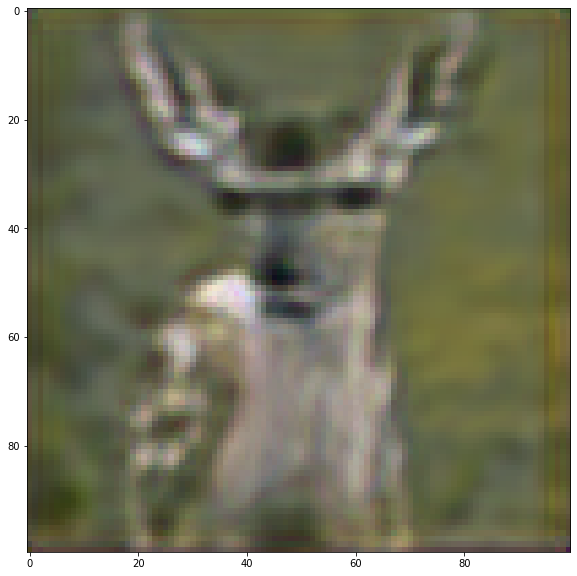

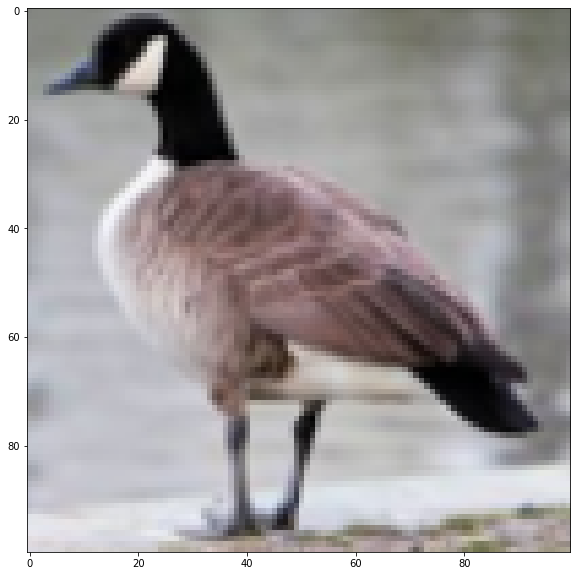

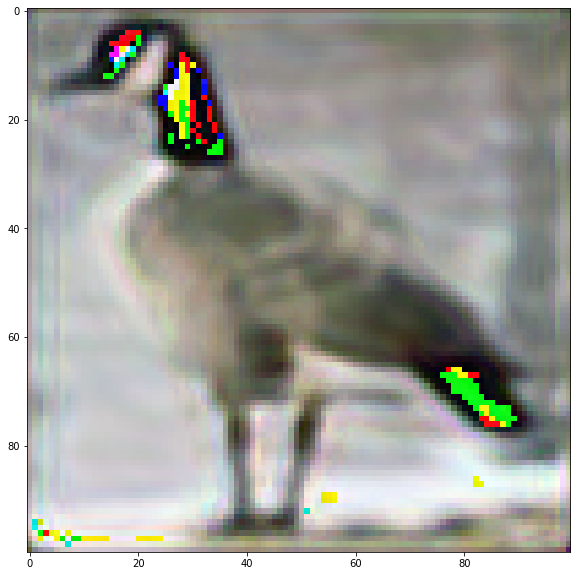

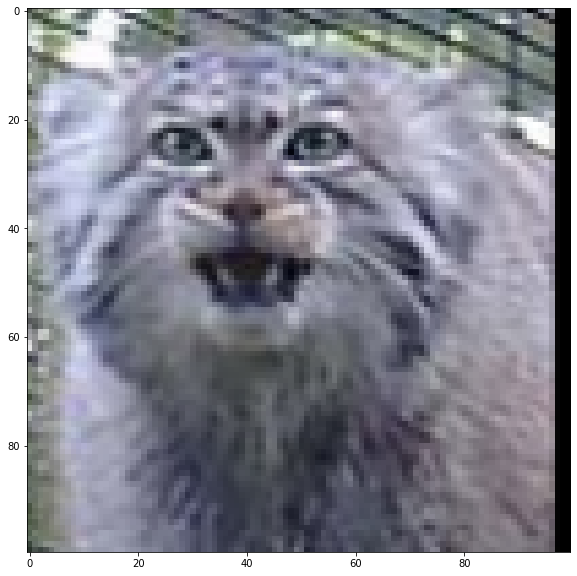

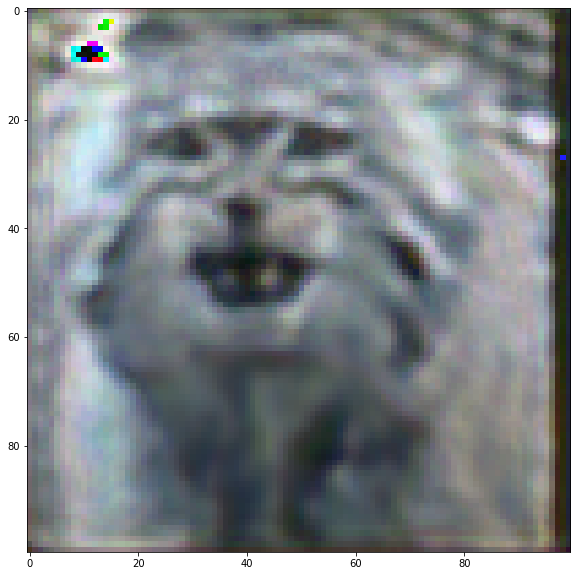

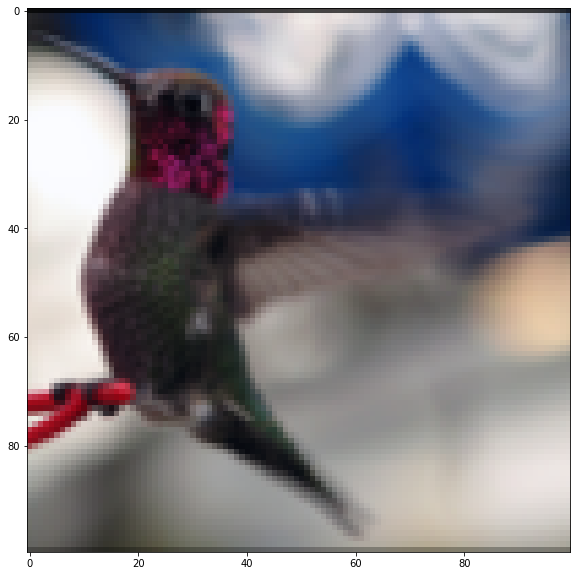

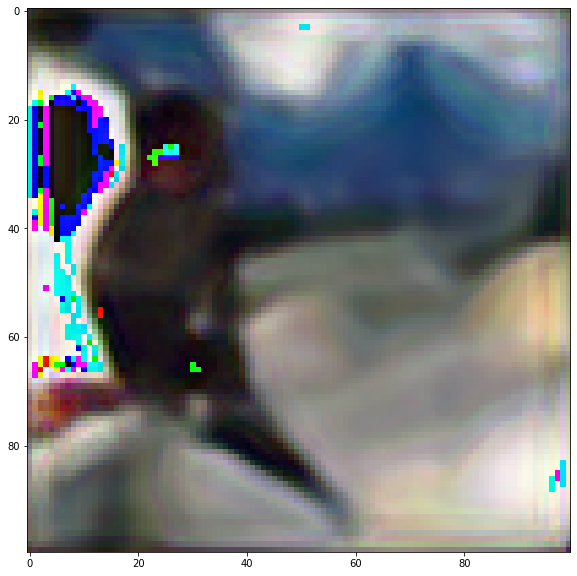

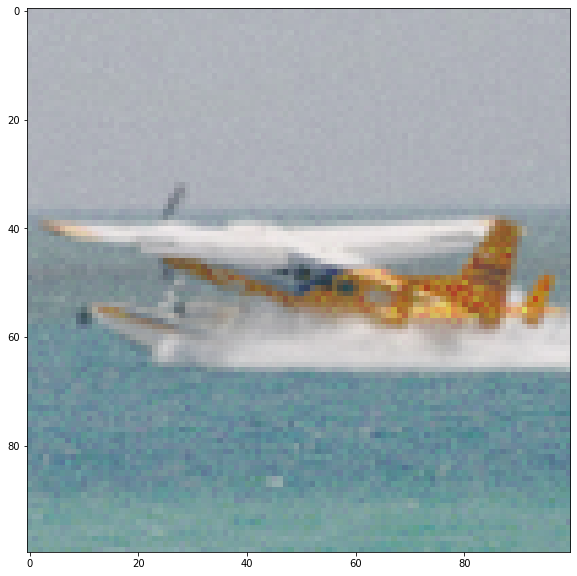

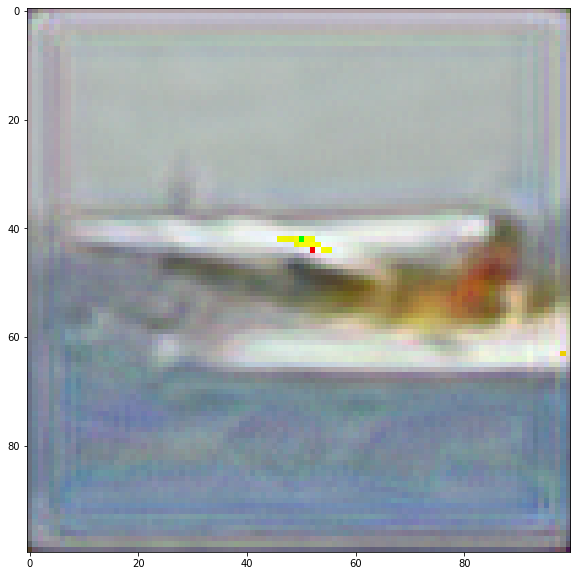

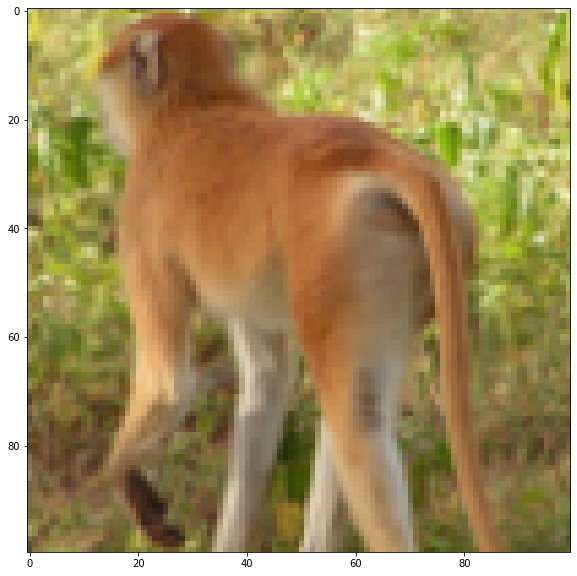

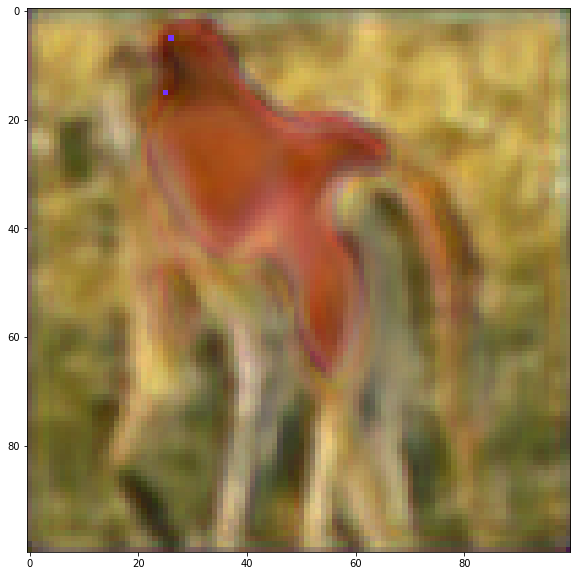

In [26]:
k = 0
with torch.no_grad():
    for data in train_dataloader:
      input, target, _, _ = data
      input, target = input.to(device)/255, target.to(device)/255
      output = model(input)
      output = (output[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
      input = (input[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

      plt.figure(figsize=(10, 10))
      plt.imshow(input)
      plt.show()

      plt.figure(figsize=(10, 10))
      plt.imshow(output)
      plt.show()
      k+=1
      if k == 10:
        break

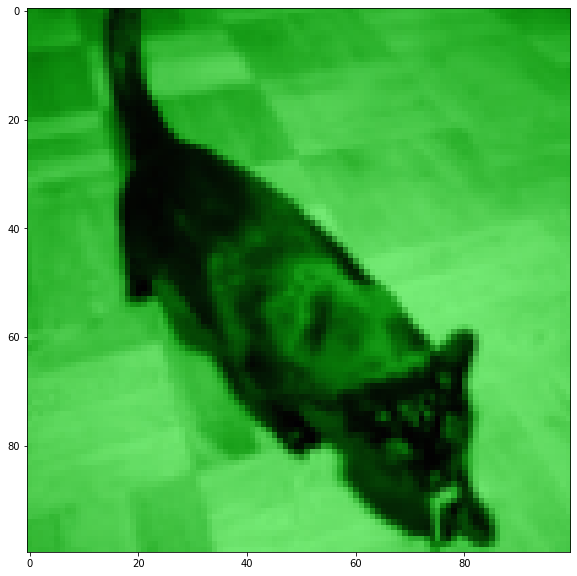

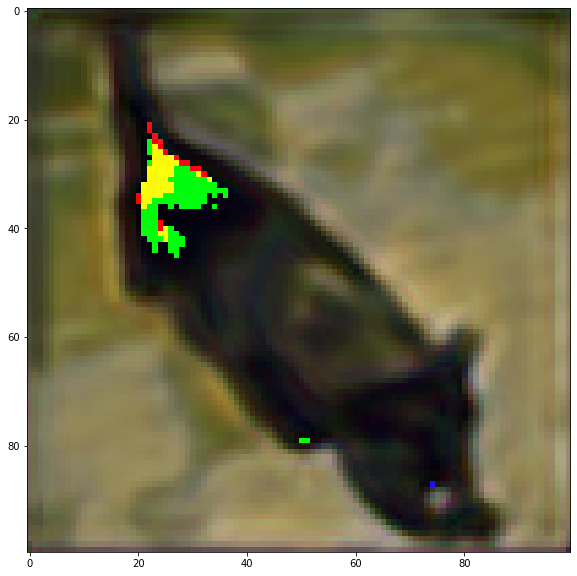

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        [                                
         
        ]
    )
    self.decoder = nn.Sequential(
        [                                
         
        ]
    )
    
  def forward(self, x):
    x = self.encoder(x)
    out = self.decoder(x)
    return out